# CW03 - GUI paper exploration 3 - Converage plots

Discard: This is explorative code for coverage plots, which ended up mostly in the CMB paper, and is part of standard swyft.

In [1]:
# Makes it easier to debug
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pylab as plt
from scipy.linalg import inv
from scipy import stats
import scipy
import torch

In [3]:
import dynesty
import swyft

## Workflow: ZoomTask

In [4]:
class ZoomTask:
    def __init__(self, sim_or_store, prior, target_obs, partition = None, simhook = None, init_bound = None):
        if not isinstance(sim_or_store, swyft.Simulator):
            self.store = sim_or_store
        else:
            self.store = swyft.MemoryStore(sim)
        
        if partition is None:
            self.partition = list(range(len(self.store.pnames)))
        else:
            self.partition = partition
            
        self.prior = prior
        self.simhook = simhook
        self.target_obs = target_obs
        
        self.init_bound = init_bound
        self.last_bound = None
        self.history = []
        
    def run(self, rounds = 10, N = 10000, train_args = {}, head = None):
        for i in range(rounds):
            self.round(N = N, train_args = train_args, head = head)
        
    def round(self, N, train_args = {}, head = None):
        bound = self.init_bound if self.history == [] else self.history[-1][1]
        
        self.store.add(N, self.prior, bound = bound)
        self.store.simulate()
        dataset = swyft.Dataset(N, self.prior, self.store, simhook = self.simhook, bound = bound)
        post = swyft.Posteriors(dataset)
        post.add(self.partition, device='cuda', head = head, tail_args = dict(p=0.2, hidden_layers = [512, 512]))
        post.train(self.partition, **train_args)
        bound = post.truncate(self.partition, self.target_obs)
        
        self.history.append([post, bound])

## Model

In [6]:
COUNTER = 0  # Counter for number of likelihood evaluations (relevant for Dynesty)

In [7]:
N = 64  # Number of data bins
SIGMA = 1.0  # Measurement uncertainty

In [8]:
# Noise-free model

# Model and reference parameters
def spec(a, b, c, d, LW = 0.3):
    global COUNTER
    COUNTER += 1
    x = np.linspace(0, 10, N)
    y_bg = a+x*b
    y_sig = c*stats.norm.pdf(x, d, LW)
    return y_bg + y_sig

def model(v):
    y = spec(v[0], v[1], v[2], v[3])
    noise = 0*np.random.randn(N)*SIGMA
    return dict(y=y + noise)

# Noise model
def noise(sim, v, sigma = SIGMA):
    #return sim
    noise = np.random.randn(N)*sigma
    return dict(y = sim['y'] + noise)

## Analysis

In [9]:
# Prior
def transform(u):
    a = scipy.stats.uniform(-2., 4.).ppf(u[0])
    b = scipy.stats.uniform(-0.4, 0.8).ppf(u[1])
    c = scipy.stats.uniform(2, 6.).ppf(u[2])
    d = scipy.stats.uniform(3.5, 1.).ppf(u[3])
    return np.array([a, b, c, d])

In [10]:
v0 = np.array([0.0, 0, 5., 4.])
obs0 = noise(model(v0), v0)

In [11]:
sim = swyft.Simulator(model, ['bg_offset', 'bg_slope', 'sig_norm', 'sig_pos'], dict(y=(N,)))
prior = swyft.Prior(transform, 4)

In [323]:
%%time
task = ZoomTask(sim, prior, obs0, simhook = noise, partition = [[0], [1], [2], [3]])
task.run(rounds = 1, N = 1000, 
         train_args = dict(batch_size = 128, max_epochs = 1, scheduler_args = dict(factor=0.5, patience = 1), early_stopping_patience = 10),
         head = swyft.DefaultHead)

Creating new store.
Store: Adding 986 new samples to simulator store.
Training: lr=0.001, Epoch=1, VL=5.536, TL=5.543
Bounds: Truncating...
Bounds: ...done. New volue is V=0.936
CPU times: user 4.14 s, sys: 353 ms, total: 4.5 s
Wall time: 5.62 s


In [325]:
post = task.history[-1][0]
samples = post.sample(100000, obs0)

(3.5, 4.5)

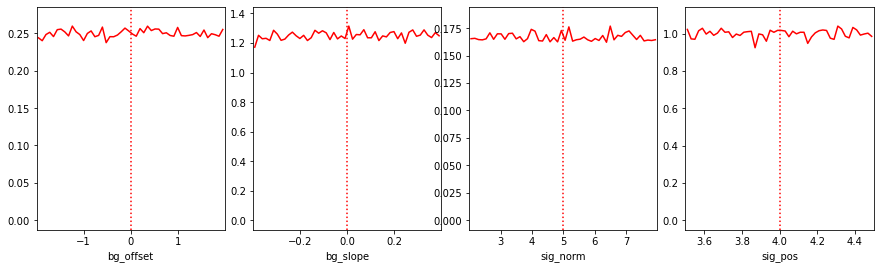

In [326]:
fig, diag = swyft.plot_1d(samples, [0, 1, 2, 3], bins = 50, figsize=(15,4), truth = v0, color='r', contours = False)
fig.get_axes()[3].set_xlim([3.5, 4.5])

### Empirical vs nominal mass

In [327]:
masses = post.empirical_mass(nobs = 1000)

In [328]:
m = masses[(0,)]['nominal']

In [329]:
probit = lambda x: scipy.stats.norm.ppf(x)
z_from_alpha = lambda alpha: probit(1-alpha/2)
alpha_from_z = lambda z: 2-scipy.stats.norm.cdf(z)*2
alpha_from_z(2)

0.04550026389635842

In [330]:
def Jefferys_interval(k, n, z = 1):
    alpha = alpha_from_z(z=z)
    lower = scipy.stats.beta.ppf(alpha/2, k+0.5, n-k+0.5)
    upper = scipy.stats.beta.ppf(1-alpha/2, k+0.5, n-k+0.5)
    return np.array([np.where(k>0, lower, 0.), np.where(k < n, upper, 1.)]).T

In [331]:
def estimate_hat_z(masses, nbins = 50, zmax = 4, z_band = 1):
    n = len(masses)
    zlist = np.linspace(0, zmax, nbins)
    tlist = 1-alpha_from_z(zlist)
    k = np.array([sum(masses < t) for t in tlist])
    r_mean = k/n    
    r_band = Jefferys_interval(k, n, z=z_band)
    z_mean = z_from_alpha(1-r_mean)
    z_band = z_from_alpha(1-r_band)
    return dict(z = zlist, mean = z_mean, upper = z_band[:,1], lower = z_band[:,0])

hat_z = estimate_hat_z(m)

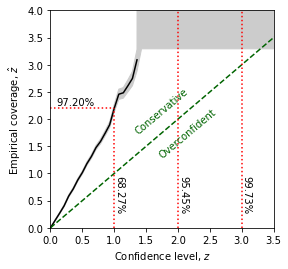

In [332]:
def plot_band(m, zmax = 3.5):
    plt.figure(figsize = (4,4))
    hat_z = estimate_hat_z(m, zmax = zmax)
    z = hat_z['z']
    plt.plot(z, hat_z['mean'], 'k')
    upper = hat_z['upper']
    upper = np.where(upper == np.inf, 100., upper)
    plt.fill_between(z, hat_z['lower'], upper, color='0.8')
    plt.plot([0, 4], [0, 4], '--', color='darkgreen')
    for t in range(1, int(zmax)+1):
        l = np.interp(t, z, hat_z['mean'])
        if l != np.inf:
            plt.plot([0, t], [l, l], ':', color='r')
            c = 1-alpha_from_z(l)
            plt.text(0.1, l+0.05, ('%.2f'%(c*100))+"%")
            plt.plot([t, t], [0, l], ':', color='r')
        else:
            plt.plot([t, t], [0, 10.], ':', color='r')
        c = 1-alpha_from_z(t)
        plt.text(t, 0.3, ('%.2f'%(c*100))+"%", rotation = -90)
    plt.xlim([0, zmax])
    plt.ylim([0, zmax + 0.5])
    plt.ylabel("Empirical coverage, $\hat z$")
    plt.xlabel("Confidence level, $z$")
    phi = 40
    plt.text(zmax/2, zmax/2 + 0.4, 'Conservative', ha = 'center', va = 'center', rotation = phi, color='darkgreen')
    plt.text(zmax/2+0.4, zmax/2, 'Overconfident', ha = 'center', va = 'center', rotation = phi, color='darkgreen')
    
plot_band(m, zmax = 3.5)
plt.savefig("coverage_not_converged2.svg")

63 98


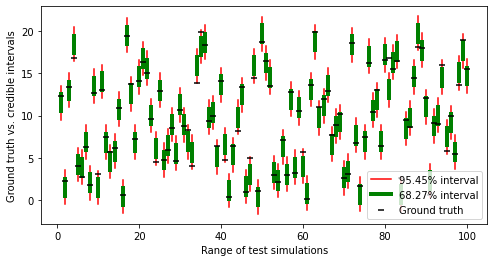

In [333]:
plt.figure(figsize=(8, 4))
c1 = 0
c2 = 0
for i in range(1, 101):
    t = np.random.rand(1)[0]*20
    o = np.random.randn(1)[0]
    if i == 1:
        l1, l2, l3 = "95.45% interval", "68.27% interval", "Ground truth"
    else:
        l1, l2, l3 = None, None, None
    plt.plot([i, i], [t-2+o, t+2+o], 'r', label=l1)
    plt.plot([i, i], [t-1+o, t+1+o], 'g', lw=4, label = l2)
    plt.scatter(i, t, marker='_', color='k', zorder=3, label = l3)
    if abs(o) < 1.:
        c1+=1
    if abs(o) < 2.:
        c2+=1

print(c1, c2)
    
plt.ylabel("Ground truth vs. credible intervals")
plt.xlabel("Range of test simulations")
plt.legend()
#plt.title("Illustration of coverage test")
plt.savefig("coverage_illustration.svg")